<a href="https://colab.research.google.com/github/PaudelSiddhanta/Rectangular_EIT/blob/main/function_optimization_testing_with_smaller_dTNvalues_n3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [129]:
import numpy as np
from scipy.optimize import minimize
import sympy as sp
from rect_grid import Node, GridStructure

In [130]:
n = 2
grid = GridStructure(n)

In [131]:
grid.conductivities

{(0, 1): np.float64(1.3406247477144055),
 (0, 2): np.float64(2.9394477448261074),
 (0, 4): np.float64(2.9394477448261074),
 (0, 11): np.float64(1.1451084421375424),
 (1, 3): np.float64(1.5270985718895826),
 (1, 5): np.float64(1.5270985718895826),
 (1, 6): np.float64(1.9781459700934945),
 (2, 3): np.float64(1.046259504382163),
 (2, 9): np.float64(1.4715595117337643),
 (2, 10): np.float64(1.5383208485910003),
 (3, 7): np.float64(1.4626343486553108),
 (3, 8): np.float64(1.2348758694822826)}

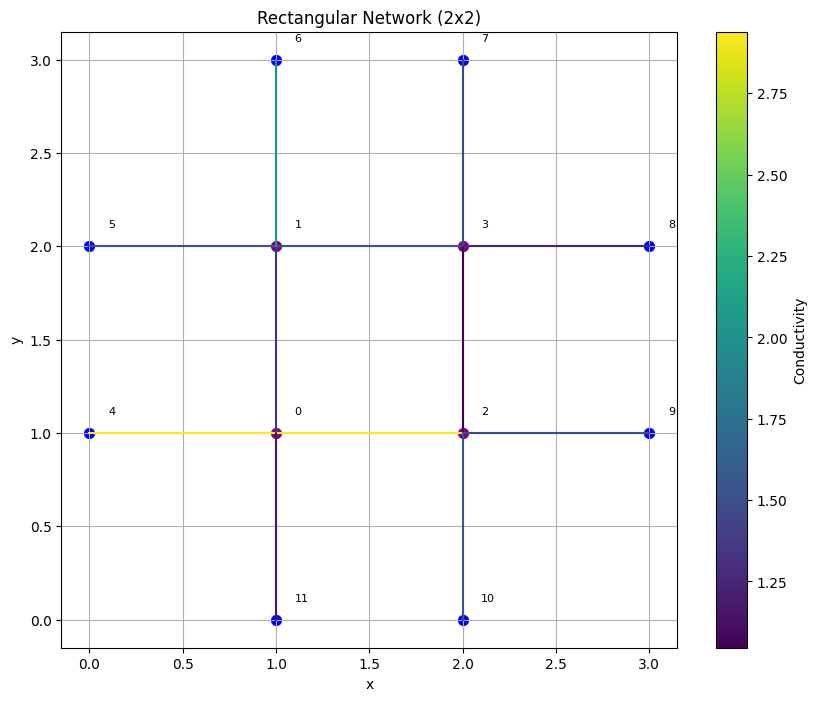

In [132]:
grid.visualize_network()

Create W1 matrix

In [133]:

def generate_dtn_data_numpy(grid, batch_size):
    dirichlet = np.zeros((batch_size, 4 * grid.n), dtype=np.float64)
    neumann = np.zeros((batch_size, 4 * grid.n), dtype=np.float64)

    for k in range(min(batch_size, 4 * grid.n)):
        # Create Dirichlet data: 1.0 at the k-th boundary index, 0 elsewhere
        dirichlet_data = {idx: 1.0 if idx == grid.boundary_index[k] else 0.0
                          for idx in grid.boundary_index}

        # Forward solve
        potentials, neumann_data = grid.solve_forward_problem(dirichlet_data)

        # Fill Dirichlet matrix
        dirichlet[k, k] = 1.0

        # Fill Neumann matrix
        for j, idx in enumerate(grid.boundary_index):
            neumann[k, j] = neumann_data[idx]

    # Concatenate [Dirichlet | Neumann] horizontally
    data = np.concatenate((dirichlet, neumann), axis=1)

    return data


In [134]:

interior_size = n**2
input_s = 8 * n
hidden_s = interior_size + 8 * n
output_s = n**2+4*n

# Initialize W1 with zeros
W1_s = sp.MutableDenseMatrix.zeros(hidden_s, input_s)

# Initialize the fixed mask: True means fixed (not trainable)
W1_mask = np.ones((hidden_s, input_s), dtype=bool)

Create W1_s : symbolic W1 matrix

In [135]:

trainable_symbols_w1=[]
# Top-left symbolic block A: (interior_size × 4n)
for i in range(interior_size):
    for j in range(4 * n):
        symbol = sp.Symbol(f'w_{i}a_{j}')
        W1_s[i, j] = symbol
        W1_mask[i, j] = False
        trainable_symbols_w1.append(symbol)

# Middle block: identity (4n × 4n), rows: interior_size to interior_size+4n, cols: 0 to 4n
for i in range(4 * n):
    W1_s[interior_size + i, i] = 1
    # Already fixed in the mask by default

# Bottom block: identity (4n × 4n), rows: interior_size+4n to end, cols: 4n to 8n
for i in range(4 * n):
    W1_s[interior_size + 4 * n + i, 4 * n + i] = 1
    # Already fixed in the mask by default


In [136]:
W1_s

Matrix([
[w_0a_0, w_0a_1, w_0a_2, w_0a_3, w_0a_4, w_0a_5, w_0a_6, w_0a_7, 0, 0, 0, 0, 0, 0, 0, 0],
[w_1a_0, w_1a_1, w_1a_2, w_1a_3, w_1a_4, w_1a_5, w_1a_6, w_1a_7, 0, 0, 0, 0, 0, 0, 0, 0],
[w_2a_0, w_2a_1, w_2a_2, w_2a_3, w_2a_4, w_2a_5, w_2a_6, w_2a_7, 0, 0, 0, 0, 0, 0, 0, 0],
[w_3a_0, w_3a_1, w_3a_2, w_3a_3, w_3a_4, w_3a_5, w_3a_6, w_3a_7, 0, 0, 0, 0, 0, 0, 0, 0],
[     1,      0,      0,      0,      0,      0,      0,      0, 0, 0, 0, 0, 0, 0, 0, 0],
[     0,      1,      0,      0,      0,      0,      0,      0, 0, 0, 0, 0, 0, 0, 0, 0],
[     0,      0,      1,      0,      0,      0,      0,      0, 0, 0, 0, 0, 0, 0, 0, 0],
[     0,      0,      0,      1,      0,      0,      0,      0, 0, 0, 0, 0, 0, 0, 0, 0],
[     0,      0,      0,      0,      1,      0,      0,      0, 0, 0, 0, 0, 0, 0, 0, 0],
[     0,      0,      0,      0,      0,      1,      0,      0, 0, 0, 0, 0, 0, 0, 0, 0],
[     0,      0,      0,      0,      0,      0,      1,      0, 0, 0, 0, 0, 0, 0, 0, 0],
[

Create the W2_s matrix: symbolic W2 matrix

In [137]:

W2_s = sp.MutableDenseMatrix.zeros(output_s, hidden_s)
W2_mask = np.ones((output_s, hidden_s), dtype=bool)
trainable_symbols_w2 = []

# Assign symmetric symbolic off-diagonal entries
for i in range(interior_size):
    node_i = grid.get_node_by_index(i)
    for j in node_i.neighbors:
        if i < j < n**2+4*n:
            sym = sp.Symbol(f'w_{i}b_{j}')
            W2_s[i, j] = sym
            W2_s[j, i] = sym
            W2_mask[i, j] = False
            W2_mask[j, i] = False
            trainable_symbols_w2.append(sym)

# Assign diagonals as negative sum of row (symbolically)
for i in range(n**2+4*n):
    row_sum = sum(W2_s[i, j] for j in range(n**2+4*n) if j != i)
    W2_s[i, i] = -row_sum
    W2_mask[i, i] = False
    # trainable_symbols_W2.append(W2[i, i])

# Assign bottom-right identity block
for i in range(4 * n):
    row = n**2 + i
    col = n**2+4*n+i
    W2_s[row, col] = 1.0
    # mask remains True (fixed)


In [138]:
W2_s

Matrix([
[-w_0b_1 - w_0b_11 - w_0b_2 - w_0b_4,                             w_0b_1,                              w_0b_2,                                  0,  w_0b_4,       0,       0,       0,       0,       0,        0,  w_0b_11,   0,   0,   0,   0,   0,   0,   0,   0],
[                             w_0b_1, -w_0b_1 - w_1b_3 - w_1b_5 - w_1b_6,                                   0,                             w_1b_3,       0,  w_1b_5,  w_1b_6,       0,       0,       0,        0,        0,   0,   0,   0,   0,   0,   0,   0,   0],
[                             w_0b_2,                                  0, -w_0b_2 - w_2b_10 - w_2b_3 - w_2b_9,                             w_2b_3,       0,       0,       0,       0,       0,  w_2b_9,  w_2b_10,        0,   0,   0,   0,   0,   0,   0,   0,   0],
[                                  0,                             w_1b_3,                              w_2b_3, -w_1b_3 - w_2b_3 - w_3b_7 - w_3b_8,       0,       0,       0,  w_3b_7,  w_3b_8,       0,     

In [139]:
#precompute fixed parts
# Precompute fixed parts
W1_fixed = np.zeros((hidden_s,input_s), dtype=np.float64)
W2_fixed = np.zeros((output_s,hidden_s), dtype=np.float64)
W1_expr = sp.lambdify(trainable_symbols_w1 , W1_s, modules='numpy')
W2_expr = sp.lambdify(trainable_symbols_w2, W2_s, modules='numpy')


In [140]:

# W1_fixed

In [141]:

def forward_pass(x, W1, W2):
    """
    x    : input matrix of shape (4n, 8n)
    W1   : weight matrix of shape (n^2 + 8n, 8n)
    W2   : weight matrix of shape (n^2 + 4n, n^2 + 8n)

    Returns:
        output of shape (4n, n^2 + 4n)
    """
    hidden = x @ W1.T            # shape: (4n, n^2 + 8n)
    output = hidden @ W2.T       # shape: (4n, n^2 + 4n)
    return output,hidden               # shape: (4n, n^2 + 4n)



def loss_function(output, n, alpha=1.0):
    """
    output: shape (4n, n^2 + 4n)
    n     : grid size
    alpha : weight for interior loss

    Returns:
        scalar loss value
    """
    batch_size = output.shape[0]           # should be 4n
    interior = output[:, :-4 * n]          # shape (4n, n^2)
    boundary = output[:, -4 * n:]          # shape (4n, 4n)

    loss = (
        alpha * np.sum(interior ** 2) + np.sum(boundary ** 2)
    ) / (2 * batch_size)

    return loss


In [142]:
params_symbolic = trainable_symbols_w1+trainable_symbols_w2

In [143]:
# params_symbolic

In [144]:
# # params_symbolic
# def build_W1_W2(param_values, W1_fixed, W2_fixed, W1_param_list, W2_param_list):
#     subs_dict = dict(zip(W1_param_list + W2_param_list, param_values))
#     W1 = W1_fixed + W1_expr(**subs_dict)
#     W2 = W2_fixed + W2_expr(**subs_dict)
#     return W1, W2
# def build_W1_W2(param_values, W1_fixed, W2_fixed, W1_param_list, W2_param_list):
#     w1_count = len(W1_param_list)
#     # Convert symbolic keys to strings for lambdify
#     subs_dict_w1 = {str(sym): val for sym, val in zip(W1_param_list, param_values[:w1_count])}
#     subs_dict_w2 = {str(sym): val for sym, val in zip(W2_param_list, param_values[w1_count:])}
#     W1 = W1_fixed + W1_expr(**subs_dict_w1)
#     W2 = W2_fixed + W2_expr(**subs_dict_w2)
#     return W1, W2

# def build_W1_W2(param_values, W1_fixed, W2_fixed, W1_param_list, W2_param_list):
#     w1_count = len(W1_param_list)
#     subs_dict_w1 = dict(zip(W1_param_list, param_values[:w1_count]))
#     subs_dict_w2 = dict(zip(W2_param_list, param_values[w1_count:]))
#     W1 = W1_fixed + W1_expr(**subs_dict_w1)
#     W2 = W2_fixed + W2_expr(**subs_dict_w2)
#     return W1, W2

def build_W1_W2(param_values, W1_fixed, W2_fixed, W1_param_list, W2_param_list):
    w1_count = len(W1_param_list)
    # Convert symbols to strings for subs_dict_w1
    subs_dict_w1 = dict(zip([str(sym) for sym in W1_param_list], param_values[:w1_count]))
    # Convert symbols to strings for subs_dict_w2
    subs_dict_w2 = dict(zip([str(sym) for sym in W2_param_list], param_values[w1_count:]))
    W1 = W1_fixed + W1_expr(**subs_dict_w1)
    W2 = W2_fixed + W2_expr(**subs_dict_w2)
    return W1, W2

In [145]:
def dloss_dy(y,alpha,batch_size = 4*n):
    dL_dy = np.zeros_like(y)  # Shape: (12, 13)
    dL_dy[:, :n**2] = alpha * y[:, :n**2] / batch_size
    dL_dy[:, n**2:] = y[:, n**2:] / batch_size
    return dL_dy




def dl_dW2(dL_dy,h,grad,grid,w1_count):# Gradient w.r.t. W2
    dW2 = dL_dy.T @ h
    w2_indices = [(i, j) for i in range(n**2) for j in grid.get_node_by_index(i).neighbors if i < j < n**2 + 4*n]
    for grad_idx, (i, j) in enumerate(w2_indices, start=w1_count):
        grad[grad_idx] = dW2[i, j] + dW2[j, i] - dW2[i, i] - dW2[j, j]

def dl_dW1(W2,dL_dy,x_data,grad):
 # Gradient w.r.t. W1
    dW1 = W2.T @ dL_dy.T @ x_data
    # grad = np.zeros(len(param_values))
    for idx, (i, j) in enumerate([(i, j) for i in range(n**2) for j in range(4*n)]):
        grad[idx] = dW1[i, j]

In [146]:

def objective(param_values, x_data, n, W1_symbolic, W2_symbolic, W1_param_list, W2_param_list, grid,alpha=1.0):
    w1_count = len(W1_param_list)
    W1, W2 = build_W1_W2(param_values, W1_symbolic, W2_symbolic, W1_param_list, W2_param_list)
    output,hidden = forward_pass(x_data, W1, W2)
    loss = loss_function(output, n, alpha)
    batch_size = output.shape[0]
    dl_dy = dloss_dy(output, alpha,batch_size)
    grad = np.zeros(len(param_values))
    dl_dW1(W2,dl_dy,x_data,grad)
    dl_dW2(dl_dy,hidden,grad,grid,w1_count)

    return loss, grad

In [147]:
# Generate data
x_data = generate_dtn_data_numpy(grid, 4 * n)
initial_guess = np.zeros(len(trainable_symbols_w1 + trainable_symbols_w2))

In [148]:
# initial_guess1 = np.random.rand(len(trainable_symbols_w1 + trainable_symbols_w2))


In [149]:
# initial_guess1

In [150]:
# W1, W2 = build_W1_W2(initial_guess, W1_fixed, W2_fixed, trainable_symbols_w1, trainable_symbols_w2)
# print("W1:\n", W1)
# print("W2:\n", W2)

In [151]:
# w1_count = len(trainable_symbols_w1)
# subs_dict_w1 = dict(zip([str(sym).replace(',', '_') for sym in trainable_symbols_w1], initial_guess[:w1_count]))
# print(list(subs_dict_w1.keys()))

In [152]:
# print(list(subs_dict_w1.keys()))

In [153]:
# result = minimize(
#     objective,
#     initial_guess,
#     args=(x_data, n, W1_fixed, W2_fixed, trainable_symbols_w1, trainable_symbols_w2),
#     method='L-BFGS-B',  # or 'CG' or others
#     options={'maxiter': 100, 'disp': True}
# )

# best_params = result.x


# result = minimize(
#     objective,
#     initial_guess,
#     args=(x_data, n, W1_fixed, W2_fixed, trainable_symbols_w1, trainable_symbols_w2,grid,1.0),
#           ## check this  x_data, n, W1_symbolic, W2_symbolic, W1_param_list, W2_param_list, alpha=1.0,grid),
#     method='L-BFGS-B',
#     options={'maxiter': 200000, 'disp': True}
# )


result = minimize(
    fun=lambda x, *args: objective(x, *args)[0],  # Extract loss
    jac=lambda x, *args: objective(x, *args)[1],  # Extract gradient
    x0=initial_guess,
    args=(x_data,  n, W1_fixed, W2_fixed, trainable_symbols_w1, trainable_symbols_w2,grid,1.0),
    method='Newton-CG',
    options={
        'maxiter': 150000,  # Maximum iterations
        'disp': True,     # Display convergence messages
        'gtol': 1e-9,     # Gradient tolerance
        'ftol': 1e-9      # Function value tolerance
    }
)

/tmp/ipython-input-153-1049987121.py:22: OptimizeWarning: Unknown solver options: gtol, ftol
  result = minimize(


Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 23
         Function evaluations: 28
         Gradient evaluations: 573
         Hessian evaluations: 0


In [154]:
# print(initial_guess)
# print("initial guess for W2 = ", initial_guess[len(trainable_symbols_w1):])
# # print("initial guess for W2 = ", initial_guess[len(trainable_symbols_w1):


In [155]:
# Output results
print("Optimization successful:", result.success)
print("Final loss:", result.fun)
print("Optimized parameters:", result.x)
print("Message:", result.message)

Optimization successful: True
Final loss: 1.851950241431748e-10
Optimized parameters: [0.43707541 0.05648119 0.07316411 0.03484481 0.02941884 0.09717327
 0.10158211 0.17026037 0.10872249 0.2721388  0.35252145 0.08247453
 0.06963166 0.03527906 0.03687967 0.04235236 0.19410864 0.03660983
 0.04742322 0.06154691 0.05196288 0.26045865 0.272276   0.07561396
 0.07003012 0.0861092  0.11154344 0.31360836 0.26477327 0.06192311
 0.06473262 0.02727993 1.3405915  2.93896591 2.93956159 1.14509646
 1.52701448 1.52709849 1.97816137 1.04629251 1.47158039 1.53834772
 1.46263772 1.23487605]
Message: Optimization terminated successfully.


In [156]:
best_params = result.x

In [157]:
grid.conductivities

{(0, 1): np.float64(1.3406247477144055),
 (0, 2): np.float64(2.9394477448261074),
 (0, 4): np.float64(2.9394477448261074),
 (0, 11): np.float64(1.1451084421375424),
 (1, 3): np.float64(1.5270985718895826),
 (1, 5): np.float64(1.5270985718895826),
 (1, 6): np.float64(1.9781459700934945),
 (2, 3): np.float64(1.046259504382163),
 (2, 9): np.float64(1.4715595117337643),
 (2, 10): np.float64(1.5383208485910003),
 (3, 7): np.float64(1.4626343486553108),
 (3, 8): np.float64(1.2348758694822826)}

In [158]:

best_params[-len(grid.conductivities):]

array([1.3405915 , 2.93896591, 2.93956159, 1.14509646, 1.52701448,
       1.52709849, 1.97816137, 1.04629251, 1.47158039, 1.53834772,
       1.46263772, 1.23487605])

In [159]:

np.array(list(grid.conductivities.values()))-best_params[-len(grid.conductivities):]

array([ 3.32503836e-05,  4.81832520e-04, -1.13841068e-04,  1.19843016e-05,
        8.40889963e-05,  8.40904035e-08, -1.54004146e-05, -3.30025319e-05,
       -2.08808863e-05, -2.68758068e-05, -3.37455444e-06, -1.76546364e-07])

now testing for less number of values


In [160]:
for i in range(4*n-1,1,-1):
  print("Value of n = ",n)
  print("total number of boundary points (4n) = ",4*n)
  print("testing with ",i,"DtN data" )
  train_data = generate_dtn_data_numpy(grid, i)
  print("training data:")
  print(train_data)
  print()
  print()
  initial_guess = np.zeros(len(trainable_symbols_w1 + trainable_symbols_w2))
  result = minimize(
    fun=lambda x, *args: objective(x, *args)[0],  # Extract loss
    jac=lambda x, *args: objective(x, *args)[1],  # Extract gradient
    x0=initial_guess,
    args=(train_data,  n, W1_fixed, W2_fixed, trainable_symbols_w1, trainable_symbols_w2,grid,1.0),
    method='Newton-CG',
    options={
        'maxiter': 150000,  # Maximum iterations
        'disp': True,     # Display convergence messages
        'gtol': 1e-9,     # Gradient tolerance
        'ftol': 1e-9      # Function value tolerance
    })
  print("Optimization successful:", result.success)
  print()
  print("Final loss:", result.fun)
  print()
  print("Optimized parameters:", result.x)
  print()
  print("Message:", result.message)
  print()
  print("grid conductivities = ")
  print(np.array(list(grid.conductivities.values())))
  print("extracted values for gamma = ")
  print(result.x[-len(grid.conductivities):])
  print()
  print()
  print()
  print(".......................................................................................")

Value of n =  2
total number of boundary points (4n) =  8
testing with  7 DtN data
training data:
[[ 1.          0.          0.          0.          0.          0.
   0.          0.          1.65474807 -0.16602657 -0.21506456 -0.10242984
  -0.08647967 -0.28565637 -0.29861596 -0.50047511]
 [ 0.          1.          0.          0.          0.          0.
   0.          0.         -0.16602657  1.11151819 -0.53832717 -0.12595065
  -0.10633786 -0.0538767  -0.05632096 -0.06467828]
 [ 0.          0.          1.          0.          0.          0.
   0.          0.         -0.21506456 -0.53832717  1.28081723 -0.16315172
  -0.13774606 -0.06978984 -0.07295605 -0.08378181]
 [ 0.          0.          0.          1.          0.          0.
   0.          0.         -0.10242984 -0.12595065 -0.16315172  1.00394314
  -0.38726474 -0.0905671  -0.09467593 -0.03990317]
 [ 0.          0.          0.          0.          1.          0.
   0.          0.         -0.08647967 -0.10633786 -0.13774606 -0.3872647

/tmp/ipython-input-160-1196901932.py:11: OptimizeWarning: Unknown solver options: gtol, ftol
  result = minimize(


Optimization terminated successfully.
         Current function value: 0.012459
         Iterations: 72
         Function evaluations: 111
         Gradient evaluations: 4629
         Hessian evaluations: 0
Optimization successful: True

Final loss: 0.012458630954340955

Optimized parameters: [-16.64494796   1.54989619   2.00389765   1.07088918   0.91695423
   2.76024175   2.88363897   0.           0.10776415   0.28650235
   0.37660777   0.09896545   0.08703783   0.02711137   0.02848208
   0.           0.20130457   0.02934193   0.03873586   0.08999524
   0.07941356   0.29235063   0.3068677    0.           0.09488218
   0.10688725   0.14051978   0.25107809   0.22110473   0.09215697
   0.09673604   0.          -0.02492874  -0.05032809   0.09455713
  -0.02432218   2.54300746   1.51984088   1.99461805   2.13368165
   1.47237314   1.54425485   1.36999577   1.20244707]

Message: Optimization terminated successfully.

grid conductivities = 
[1.34062475 2.93944774 2.93944774 1.14510844 1.52709